# Your Classifier is Secretly an Energy-based Model

[Grathwohl et al. (2020)](https://openreview.net/forum?id=Hkxzx0NtDB)

Objective / initial thoughts:

 * Train an energy-based model to generate hand-written digits (not MNIST, but the smaller sklearn dataset).
 * The model should "look like" a classifier.
 * Unsupervised training: the model should output a low energy score for e.g. zeros. $p_\theta(x)$ should be low.
 * Then we can sample zeros from the model using Langevin dynamics.

**Eq. 1** from the paper: $\displaystyle p_\theta(x)=\frac{\exp(-E_\theta(x))}{Z(\theta)}$

 * We want to maximize ${\displaystyle\log p_\theta(\mathcal{D})=\log\prod_{x\in\mathcal{D}}p_\theta(x)}$, which is the probability of the data according to our model
 * We model the energy function $E$ in $\displaystyle p_\theta(x)=\frac{\exp(-E_\theta(x))}{Z(\theta)}$ using a network. It outputs only one scalar.
 * **Eq. 2** is the gradient of $p(x)$ wrt. the parameters.
   * The right side can be computed "as usual" (forward pass and `(-net(x)).backward()` call – there is no loss).
   * The left side requires (a) sampling an $x'$ from the current model and (b) computing `net(x_prime).backward()`. Difficult is (a).

**Eq. 3** is a possible implementation of (a). Sample an $x_0$ (set `requires_grad=True`) and 

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import torch
from torch import Tensor
from torchsummary import summary
from tqdm import tqdm
from typing import *

In [2]:
dataset = sklearn.datasets.load_digits()
data_np, labels_np = dataset['data'], dataset['target']
data_np = data_np[labels_np < 4]
del labels_np

data = torch.from_numpy(data_np.astype(np.float32))
data = data / data.max()  # Normalize between [0, 1]
IMG_DIM = data.shape[1]
data.shape, data.dtype

(torch.Size([720, 64]), torch.float32)

In [3]:
def imshow(x: Tensor) -> None:
    plt.imshow(x.reshape((8, 8)));

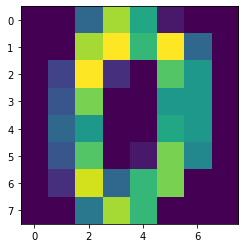

In [4]:
imshow(data[0])

## Model Definition

In [5]:
class Energy(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        activation_fn = torch.nn.SiLU()

        self.convs = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3)),
            activation_fn,
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)),
            activation_fn,
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4, 4)),
            activation_fn,
        )

        self.linear = torch.nn.Linear(in_features=64, out_features=1)
    
    def forward(self, x: Tensor) -> Tensor:
        x = x.view(-1, 1, 8, 8)
        x = self.convs(x)
        x = x.view(-1, x.shape[1])
        return self.linear(x)


class EnergyMLP(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        activation_fn = torch.nn.SiLU()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(64, 16),
            activation_fn,
            torch.nn.Linear(16, 8),
            activation_fn,
            torch.nn.Linear(8, 1),
        )
    
    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x.view(-1, 64))

In [6]:
summary(Energy(), data[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 6, 6]             160
              SiLU-2             [-1, 16, 6, 6]               0
            Conv2d-3             [-1, 32, 4, 4]           4,640
              SiLU-4             [-1, 32, 4, 4]               0
            Conv2d-5             [-1, 64, 1, 1]          32,832
              SiLU-6             [-1, 64, 1, 1]               0
            Linear-7                    [-1, 1]              65
Total params: 37,697
Trainable params: 37,697
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.14
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


## Inference

**Eq. 3**. This is also needed for $x'$ in the training loop in Eq. 2.

In [7]:
ALPHA_START = 1e-1
# This is tricky because we don't want to decay during the Langevin dynamics phase.
ALPHA_END = 1e-3

WARMUP_STEPS = 100
LANGEVIN_SKIPS = 100

In [8]:
def generate(
    energy_fn: Callable[[Tensor], Tensor], num_samples: int, langevin_skips=LANGEVIN_SKIPS
) -> Iterable[np.ndarray]:
    num_langevin_steps = num_samples * langevin_skips
    num_total_steps = num_langevin_steps + WARMUP_STEPS
    
    x_0 = torch.rand(size=(8, 8))  # same range as the data distribution, [0, 1]
    x_0.requires_grad = True
    alpha_scheduled = np.linspace(ALPHA_START, ALPHA_END, num=num_total_steps)

    x_i = x_0
    for steps in range(num_total_steps):
        eps = torch.randn(x_0.shape) * alpha_scheduled[steps]
        d_energy_dx = torch.autograd.grad(outputs=energy_fn(x_i), inputs=x_i)[0]
        x_i = x_i - alpha_scheduled[steps] / 2 * d_energy_dx + eps
        
        in_langevin_phase = steps >= WARMUP_STEPS
        if in_langevin_phase:
            steps_in_langevin_phase = steps - WARMUP_STEPS
            if steps_in_langevin_phase % langevin_skips == 0:
                yield x_i.detach()

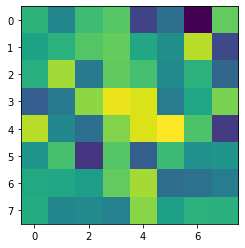

In [9]:
energy = Energy()
for generated_img in generate(energy, num_samples=1):
    plt.figure()
    imshow(generated_img.numpy());

## Training

In [17]:
NUM_STEPS = 150
LEARNING_RATE = np.linspace(5e-2, 5e-4, NUM_STEPS)
BATCH_SIZE = 40
MC_SAMPLES = 10
SAMPLER_RESTARTS = 40

In [18]:
energy = Energy()
opt = torch.optim.Adam(params=energy.parameters(), lr=LEARNING_RATE[0])
log = defaultdict(list)

for steps in tqdm(range(NUM_STEPS)):
    opt.param_groups[0]['lr'] = LEARNING_RATE[steps]
    opt.zero_grad()
    
    # left side of Eq. 1 (MCMC)
    x_primes = torch.stack([x for x in generate(energy, MC_SAMPLES) for _ in range(SAMPLER_RESTARTS)])
    logits_mcmc = torch.mean(energy(x_primes))
    log['logits_mcmc'].append(logits_mcmc.detach().numpy())
    
    batch = data[np.random.randint(0, len(data), size=BATCH_SIZE)]
    # right side of Eq. 2 ("normal" model training)
    logits_data = torch.mean(energy(batch))
    log['logits_data'].append(logits_data.detach().numpy())
    
    log_px = (logits_mcmc - logits_data)  # possibly an inaccurate name
    
    (-log_px).backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(energy.parameters(), max_norm=1)
    
    opt.step()

100%|██████████████████████████████████████████████████████████████| 150/150 [00:56<00:00,  2.68it/s]


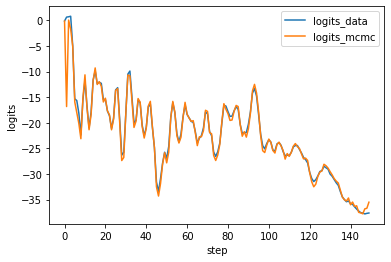

In [39]:
plt.plot(log['logits_data'], label='logits_data')
plt.plot(log['logits_mcmc'], label='logits_mcmc')
plt.xlabel('step')
plt.ylabel('logits')
plt.legend();

## Qualitative Evaluation

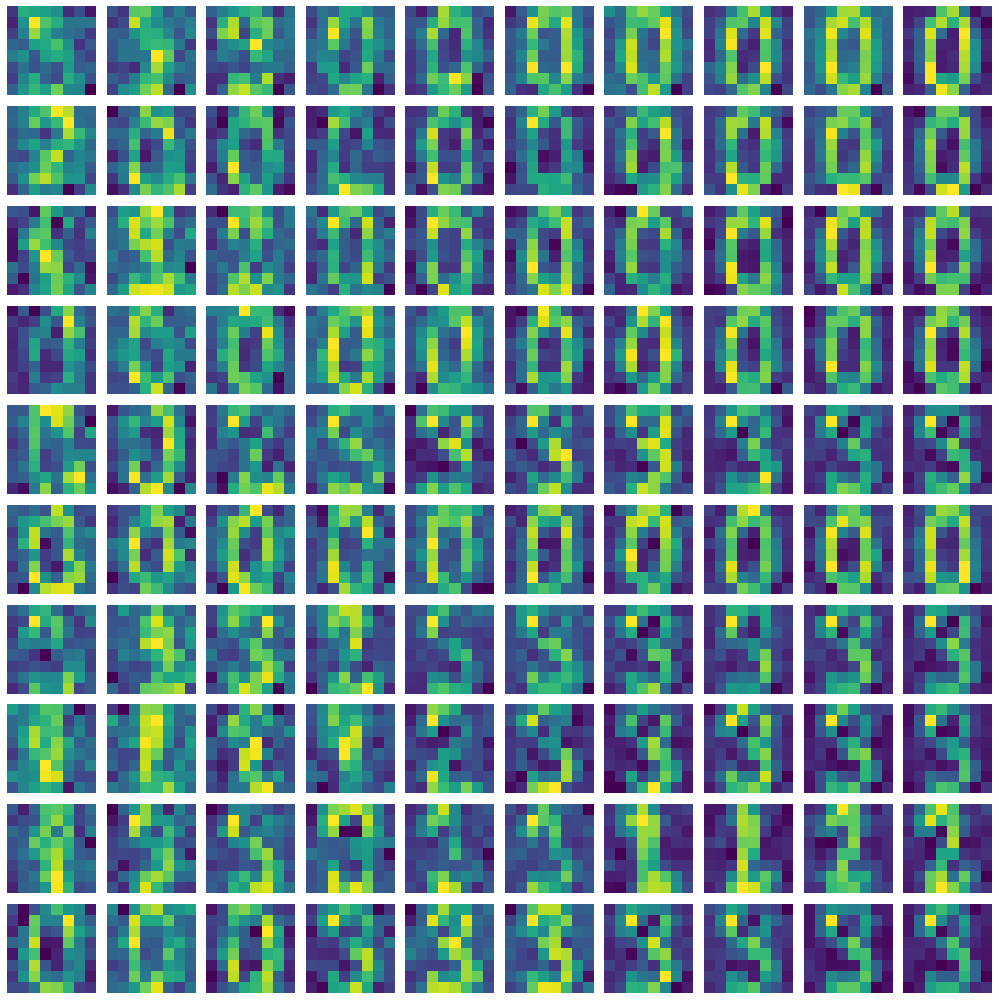

In [40]:
num_calls = 10
num_samples = 10

fig, ax = plt.subplots(num_calls, num_samples, figsize=(14, 14))

for i in range(num_calls):
    for j, x_sample in enumerate(generate(energy, num_samples=num_samples, langevin_skips=500)):
        ax[i][j].imshow(x_sample.numpy())
        ax[i][j].axis('off')

plt.tight_layout()

## Comments

**End of session notes**:

 * Why do logits/grads move together?
 * What causes the occasional pathologies in training/gradients/logits which we saw when training for 1k steps?
 * Which hparams do what?
 * Decaying of alpha _during_ the Langevin dynamics phase seems wrong, but is effective.
 * Lack of diversity across classes and conditioning on classes?
 * Do sampler restarts exist in the literature? We added them just spontaneously without reference. Balance between sampler restarts and MC samples (per sampler run). (Our hparams `MC_SAMPLES = 10; SAMPLER_RESTARTS = 40;`.)


**Further reading** (mainly from above Eq. 3 in the paper):

 * [A Theory of Generative ConvNet](https://arxiv.org/abs/1602.03264)
 * [Implicit Generation and Generalization in Energy-Based Models](https://arxiv.org/abs/1903.08689)
 * [Learning Non-Convergent Non-Persistent Short-Run MCMC Toward Energy-Based Model](https://arxiv.org/abs/1904.09770)